In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import scipy.stats as sp 
import matplotlib.pyplot as plt
from statsmodels.stats import proportion as proportion
from statsmodels.stats import power as smp

%matplotlib inline
sns.set(rc={"figure.figsize": (14, 6)})

### Подготовим данные

In [2]:
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/B4QnY5D5EtKa-A', sep=',', engine='python')  # noqa: E501
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/jP_BAw_oxS3law', sep=',', engine='python')  # noqa: E501
purchases = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/AmucCdboEaowhA', sep=',', engine='python')  # noqa: E501
# считываем файлы

In [3]:
active_users.isna().sum()  # оценим наличие NA в каждом датафрейме

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [4]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [5]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

Появляется закономерный вопрос: каким методом объединить датафреймы? <br>
Мы видим, что в датафрейме с покупками(**purchases**) у нас всего 540 значений - значит, у остальных активных юзеров покупок не было, и мы сможем проставить по ним нулевые значения вместо NA.<br>
<br>
В датафрейме с описанием активных пользователей (**active_users**) 8341 юзер, а в датафрейме разбиения по группам (**groups**) почти в 9 раз больше - 74576. Количество уникальных юзеров >8000 достаточно большое, чтобы делать по такому количеству статистически значимые выводы на всю совокупность пользователей **groups**.

In [6]:
df = groups.merge(active_users, on='user_id', how='inner')
df = df.merge(purchases, on='user_id', how='left')
df = df.fillna(0)
df
# объединим groups и и active users по столбцу с id пользователей, выбрав только те строки, 
# по которым у нас есть данные из active_users, а затем присоединим purchases, 
# и если значение NA, значит, оплаты не было - поставим в эти строки 0

user_id group country platform     sex  revenue
0        1488     B  Russia  android    male      0.0
1        5125     B  Russia      ios  female      0.0
2        3196     A  Russia      ios  female      0.0
3        1749     B  Russia  android    male      0.0
4        4994     B  Sweden  android    male      0.0
...       ...   ...     ...      ...     ...      ...
8336     1010     B  Sweden  android    male      0.0
8337     7785     A  Sweden  android    male      0.0
8338     1783     B  Russia      ios  female      0.0
8339     1164     A  Sweden  android    male      0.0
8340     6282     B  Russia  android  female      0.0

[8341 rows x 6 columns]

In [7]:
df['user_id'] = df['user_id'].astype(str)
df.dtypes
# Заменим тип данных для user_id - для нас это просто имена

user_id      object
group        object
country      object
platform     object
sex          object
revenue     float64
dtype: object

In [8]:
purchases.shape

(541, 2)

In [9]:
df.query('revenue > 0').shape

(392, 6)

Здесь обнаруживается интересная особенность. Часть пользователей совершила покупку в  текущий период, но при этом не попал в датафрейм с активными пользователями. Это может произойти по одной из двух причин:
1. С пользователей списалась ежемесячная транзакция. В таком случае они представляют мало интереса для конкретного исследования и ни ухудшают, ни улучшают данные теста
2. Ошибка при сборе данных

Рассмотрим данные по категориям

In [10]:
df[df['group'] == "A"].shape

(1538, 6)

In [11]:
df[df['group'] == "B"].shape

(6803, 6)

Заметим, что наши группы также отличаются по размерам. К счастью, группа  A достаточно большая, чтобы допустить, что поведение пользователей в генеральной совокупности будет аналогичным <br>
Однако важно понять, есть ли дисбаланс внутри данных по категориям

In [12]:
def categories(df, category, group):
    for cat in category:
        data = df.groupby([group, cat])\
            .agg({'user_id': 'count'}).reset_index()        
        sns.catplot(x=group, y='user_id', hue=cat, 
                    data=data, kind='bar',
                    height=3, aspect=1.5, 
                    palette=['lightgreen', 'lightblue'])
        plt.xlabel('groups')
        plt.ylabel('qunatity')
# Напишем функцию для визуального представления распределений 

In [13]:
category = ['country', 'platform', 'sex']

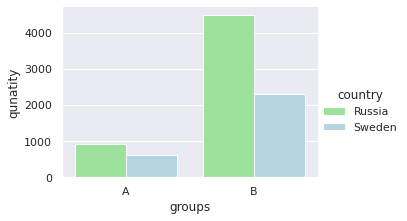

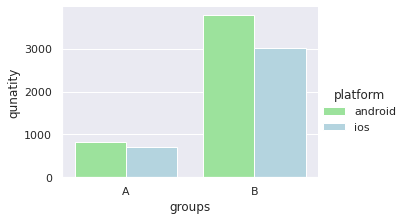

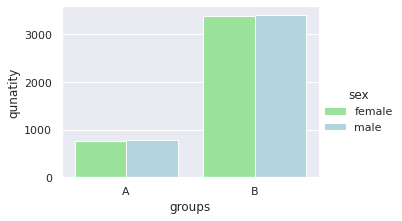

In [14]:
categories(df, category, 'group')

Мы видим, насколько критичная разница по категории 'country' в экспериментальной группе, а также заметный дисбаланс в категории 'platform'. Это может указывать на ошибку сплитования и иметь влияние на A/B тест

### Выберем метрики
Так как среди целей нашего приложения главенствующая - извлечение прибыли - исходим из того, что тестируемые изменения должны повышать наши доходы. Очевидный способ измерить доходы в нашем экперименты - **оценить изменение доходов (revenue).** <br> 
Стоит быть внимательным: категория может вырасти для одних категорий пользователей (из разных стран, разного гендера, пришедших с разных платформ), при этом упасть для других, поэтому **важно наблюдать статистическое значимое улучшение для всех категорий**, либо улучшение почти для всех и минорные ухудшения для одной из них, в противном случае эксперимент будем считать неудачным. <br>
На мой взгляд, наилучшим методом оценки могла бы быть конверсия, однако для оценки ratio метрики у нас нет "числителя", а есть только показатель дохода (**revenue**). Поэтому логичным будет использовать его следующим образом:
1. Оценить, изменилась ли конверсия активных пользователей в покупку в тестовой группе относительно контрольной (**CR**)
2. Оценить, изменился ли размер среднего чека на заплатившего пользователя (**ARPPU**)
3. Оценить, изменился ли размер среднего чека на всех пользователей (**ARPU**)
4. Оценить, есть ли изменение показателей по категориям

In [15]:
df['purchase'] = 0
df.loc[(df.revenue > 0), 'purchase'] = 1
# Создадим столбец purchase, в котором укажем, была ли покупка или нет

In [16]:
df.query('purchase == 1').purchase.count() / df.agg({'purchase': 'count'})
# Оценим количество покупок

purchase    0.046997
dtype: float64

На этом этапе мы видим, что процент покупок среди активных пользователей по обеим группам в целом **не превышает 5%**

### A/A тест 
На практике, конечно, проверка систем сплитования уже была проведена, но в моем примере мне ничего неизвестно о ней, кроме того, что по категориям 'country' и 'platform' в экспериментальной группеданные неравномерно распределены, и есть вероятность, что весь тест не имел смысла. К счастью, у нас есть возможность симулировать A/A тест синтетически

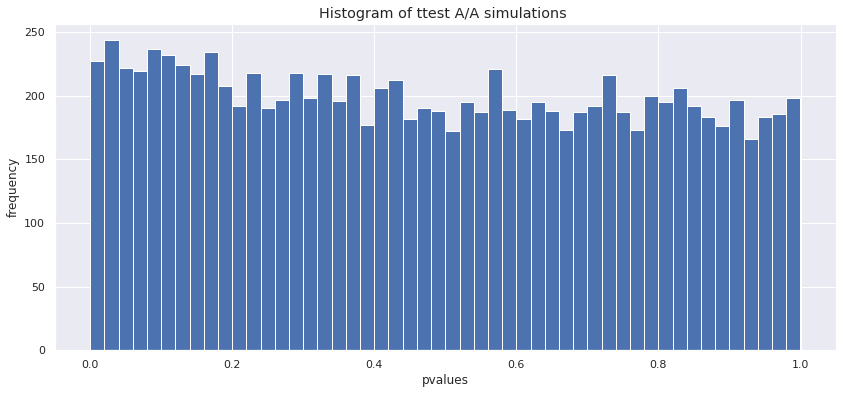

0.0581

In [17]:
simulations = 10000  # количество симуляций
n_s = 300  # количество "пользователей"
res = []
df0 = df.query('group == "A"')  # разделяем экспериментальные группы
df1 = df.query('group == "B"')
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df0['revenue'].sample(n_s, replace=False).values
    s2 = df1['revenue'].sample(n_s, replace=False).values
    res.append(sp.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа - его мы установим на уровне 0.05
sum(np.array(res) < 0.05) / simulations

Прежде всего повторим симуляцию выше ещё пару раз: возможно, имеет место элемент случайности, так как статистически могут быть ложноположительные и ложноотрицательные результаты. Но и эти тесты показали **p-value выше уровня альфы.** <br>
При повторных тестах результат иногда попадал ниже уровнят альфы - но в целом, это печальная новость. <br>
Чтобы понять, в чем проблема в системе сплитования, взглянем на средние распределения значений по категориям platfrom, sex, country в группах

In [18]:
df.groupby(['group', 'platform'], as_index=False).agg({'revenue': 'mean'})

group platform    revenue
0     A  android  47.839329
1     A      ios  47.869318
2     B  android  54.999208
3     B      ios  62.941313

In [19]:
df.groupby(['group', 'sex'], as_index=False).agg({'revenue': 'mean'})

group     sex    revenue
0     A  female  42.107570
1     A    male  53.364331
2     B  female  62.209316
3     B    male  54.851656

In [20]:
df.groupby(['group', 'country'], as_index=False).agg({'revenue': 'mean'})

group country    revenue
0     A  Russia  38.696175
1     A  Sweden  61.301766
2     B  Russia  53.304096
3     B  Sweden  68.659022

Здесь заметим, что хотя пользователей пользователей iOS в группе B меньше, средний чек больше; пользователей из Швеции меньше только в группе B, а средний чек по этой категории выше в обеих группах <br>
Это говорит о критичности правильного сплитования: мы могли бы использовать эти закономерности для заключения, но **в таких условиях этого сделать будет уже нельзя**

In [21]:
sum(np.array(res) < 0.01) / simulations

0.0114

Симуляция со скорректированной альфой в пределах 1% тоже дает неоднозначный результат: при повторных тестах значения попадают вокруг неё. Мне видится корректным **продолжить тестирование**, раз данные уже собраны, тест проведен и финансовые и трудоресурсы затрачены, однако при выводах будем иметь в виду, что имеет место ошибка в системе сплитования <br>
### A/B тест
Теперь мы можем приступить к A/B тесту.  <br> 
Напомню, что в качестве контрольной группы выступает группа A, тестовой - с изменениями - B. <br> 
**Начнем с оценки изменений конверсии в покупку (CR)**

In [22]:
df_CR = df.query('purchase == 1').groupby('group', as_index=False).agg({'user_id': 'count', 'purchase': 'count'})
df1 = df.groupby('group', as_index=False).purchase.count()
df_CR['CR'] = df_CR['purchase'] / df1['purchase']
df_CR.rename(columns={'user_id': 'all_users', 'purchase': 'users_paid'}, inplace=True)
df_CR['all_users'] = df.groupby('group', as_index=False).agg({'user_id': 'count'}).user_id

df_CR
# Выделим тех пользователей по группам, кто совершил покупку, а также всех вместе,
# и найдем конверсию в покупку

group  all_users  users_paid        CR
0     A       1538          78  0.050715
1     B       6803         314  0.046156

Конверсия в тестовой группе стало ***немного ниже***, чем в контрольной

In [23]:
chi2, pvalue, table = proportion.proportions_chisquare(df_CR['users_paid'], df_CR['all_users'])
print("p-value =", pvalue)

p-value = 0.44547028437158964


p-value очень большой: **нельзя отклонить нулевую гипотезу** об отсутствии статистически значимых различий. <br>
Однако не всё однозначно: оценим effect size и используем его для оценки мощности критерия

In [24]:
ES = np.sqrt(((df_CR['CR'][0] / 100) - (df_CR['CR'][1] / 100) ** 2) / df_CR['CR'][1] / 100)

In [25]:
smp.GofChisquarePower().solve_power(ES, nobs=min(df_CR['all_users']), alpha=0.5)

0.5349389082644214

При p-value = 0.05 и заданных условиях мощность оказалось катастрофически маленькой: всего 0.5 - это означает, что увидеть статистически значимую разницу между группами крайне маловероятно, если такая разница есть (и очень высока вероятность ошибки II рода). Для точного определения значимости данных при применении хи-квадрата ***необходимо увеличить мощность теста*** - например, значительно увеличив размер выборок групп. <br>
<br>
Теперь оценим изменился ли **размер среднего чека на платящего пользователя (ARPPU)**

In [26]:
df_arppu = df.query('purchase == 1')
df_arppu.groupby('group', as_index=False).revenue.mean().round(2)

group  revenue
0     A   943.56
1     B  1267.88

На первый взгляд, в экспериментальной группе (B) вырос средний чек по платящим пользователям

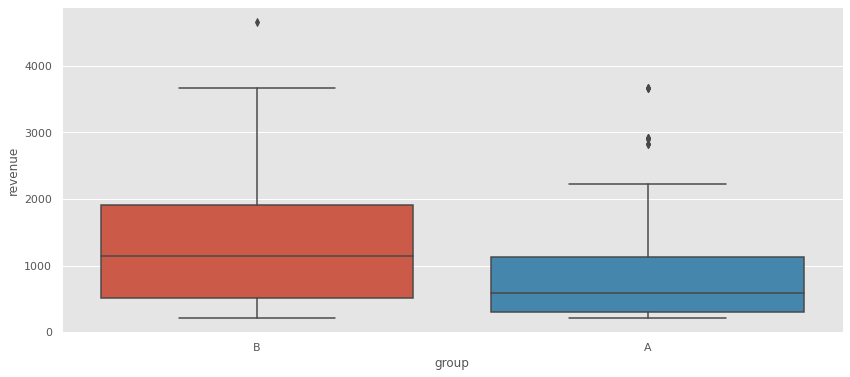

In [27]:
sns.boxplot(x="group", y="revenue", data=df_arppu)
# Оценим распределения дохода по группам 

Данные распределены неплохо: **мы видим заметное улучшение в тестовой группе (B)**, в том числе медианного значения

In [28]:
sp.ttest_ind(df_arppu[df_arppu['group'] == 'A'].revenue, df_arppu[df_arppu['group'] == 'B'].revenue)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

**p-value показывает статистическую значимость изменения**
<br>
<br>
Выбросы данных часто имеют колоссальное влияние, и в наем исследовании также могут влиять. Обычно у нас есть несколько способов справится с ними, среди которых: избавление от выбросов, сглаживание Лапласа и применение методов, увеличивающих мощность критериев <br>
Отбрасывание выбросов существенно изменяет выборку и некорректен в финансовом анализе. Предпочтем один из более сложных методов улучшения качества A/B теста, но более эффективных - ***bootstrap*** или ***bucket-исследование***

In [29]:
def bootstrap(
    data_column_1,
    data_column_2,
    boot_it,  # количество бутстрэп-подвыборок
    statistic=np.mean,
    bootstrap_conf_level=0.95
):

    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))        
    pd_boot_data = pd.DataFrame(boot_data)                               
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])        
    p_1 = sp.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = sp.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print(f'pvalue = {p_value}')      
    return {"boot_data": pd_boot_data, 
            "ci": ci}

# Напишем функцию для бутстрэп-сравнения

In [30]:
def vizualization(pd_boot_data, ci, title):   
    plt.figure(figsize=(15, 5))
    sns.histplot(pd_boot_data[0], bins=50, color='green')    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--')
    plt.vlines(x=0, ymin=0, ymax=100, color='red', linestyle='-')    
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title(title)
    plt.show()
    
# Напишем функцию для визуализации бутстрэп-сравнения

pvalue = 3.0829434661034626e-06


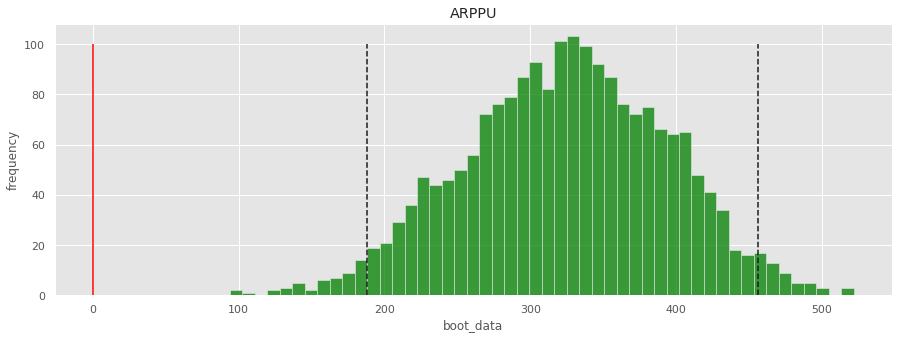

In [31]:
control = df_arppu[df_arppu['group'] == 'A'].revenue
test = df_arppu[df_arppu['group'] == 'B'].revenue
# выделим контрольную и тестовую группы

bootstrap_result = bootstrap(test, control, 2000)
boot_data = bootstrap_result['boot_data']
# применяем bootstrap

ci = bootstrap_result['ci']
# выделим доверительные интервалы

vizualization(boot_data, ci, 'ARPPU')
# визуализируем

p-value стал ещё меньше, чем в стандартном t-тесте, ноль категорически не попадает в доверительный интервал, а значит, **различия в контрольной и тестовой группе статистически значимы** <br>
<br>
**ARPU** 

In [32]:
df.groupby('group', as_index=False).revenue.mean().round(2)

group  revenue
0     A    47.85
1     B    58.52

**ARPU в тестовой группе стал выше**. Оценим, насколько это статистически значимо

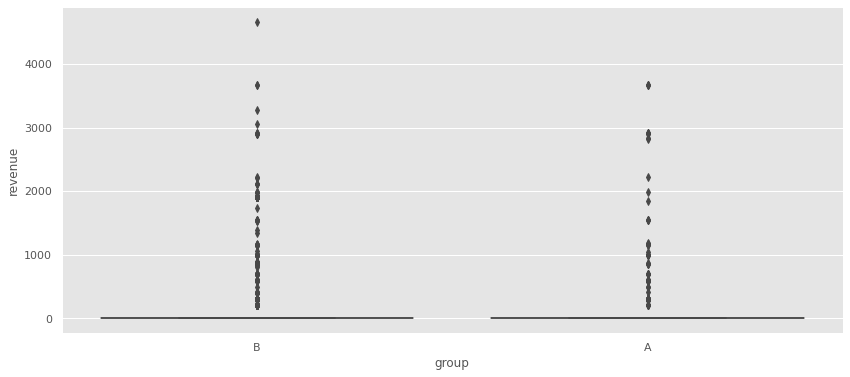

In [33]:
sns.boxplot(x="group", y="revenue", data=df)

Мы видим, что нулевые значения сильно "прижимают" боксплоты, делая всех заплативших пользователей статистическими выбросами. Конечно, мы не можем отбросить эти данные, но стандартный t-тест покажет удручающие результаты, поэтому **без bootstrap не обойтись**

In [34]:
sp.ttest_ind(df[df['group'] == 'A'].revenue, df[df['group'] == 'B'].revenue)

Ttest_indResult(statistic=-1.2134888974665123, pvalue=0.22497732609154453)

pvalue = 0.042977301837408534


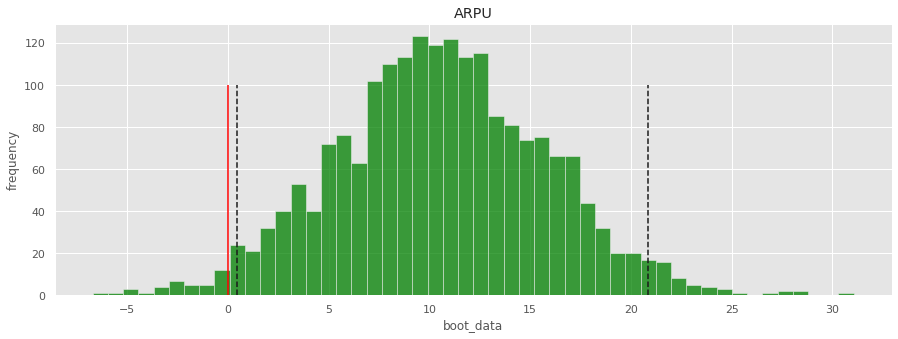

In [35]:
control_arpu = df[df['group'] == 'A'].revenue
test_arpu = df[df['group'] == 'B'].revenue

bootstrap_result = bootstrap(test_arpu, control_arpu, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']

vizualization(boot_data, ci, 'ARPU')

С ARPU ситуация гораздо  интереснее: t-тест, разумеется, показал огромный p-value, а bootstrap в пределах 0.05, причем повторные эксперименты иногда приводят нас к пограничным значениям p-value, а значит, высок риск ошибки I рода. <br> 
Почему так происходит? Из границы 95% доверительного интервала видно выпадение значений, пересекающих ноль - ***вероятно, в данных есть некоторая величина, зашумляющая данные***. Наиболее корректным решением будет проведение множеств тестов по каждой из категорий. <br>
В этом случае позникает другая проблема - ошибки множественных сравнений, но только так мы сможем выделить источник затруднений и обнаружить открытие в данных. <br>
<br>
В этом проекте я опущу подробности измерения ARPU методом bootstrap по каждой категории пользователей - гендеру, платформе и стране - оставив лишь единственную категорию, по которой ***p-value оказался заметно выше уровня 0.05***

pvalue = 0.853650834655494


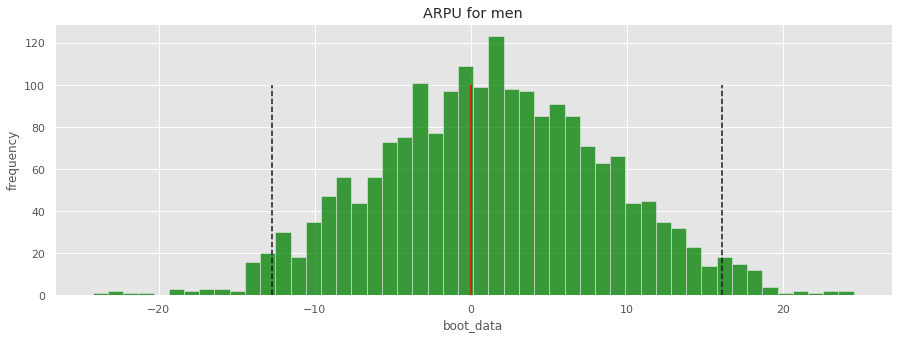

In [36]:
control_arpu_men = df[(df['group'] == 'A') & (df['sex'] == "male")].revenue
test_arpu_men = df[(df['group'] == 'B') & (df['sex'] == "male")].revenue

bootstrap_result = bootstrap(test_arpu_men, control_arpu_men, 2000)
boot_data = bootstrap_result['boot_data']
ci = bootstrap_result['ci']

vizualization(boot_data, ci, 'ARPU for men')

**Для мужчин показатель изменения ARPU не является статистически значимым** и более того, заметная разница в цифровом выражении практически отсутствует:

In [37]:
df.query('sex == "male"').groupby('group', as_index=False).revenue.mean().round(2)

group  revenue
0     A    53.36
1     B    54.85

### Заключение
**Сложности** <br>
* В проведенном испытании **имеет место ошибка системы сплитования данных** - к сожалению, это существенно уменьшает качество статистической оценки данных. <br>
* Часть пользователей, попавшие в исследование, не заходили в приложение в течение периода исследования и не являются активными пользователями. Стоит понимать, что мы рассматривали этих пользователей в оценке эффективности изменений исключительно потому, что они, вероятно, являются нашими постоянными пользователями, оплачивающими подписку, однако при формировании выборки в следующих исследованиях приложения таких пользователей не стоит включать. 

**Результаты** <br>
* **Конверсия в покупку снизилась на 8.8%**, однако статистическую достоверность такие сравнения не проявляют. Для достоверного исследования необходимо увеличить мощность теста. <br>
<br>
* **ARPPU статистически значимо увеличился на 34%.** Показатели t-теста и bootstrap таковы, что можно утверждать об эффективности влияния обновления на ARPPU даже с учетом проблем в сплитовании.<br>
<br>
* **ARPU статистически значимо увеличился для всех категорий, кроме мужчин.** Общий уровень повышения ARPU составляет **22%** 

**Выводы** <br>
Изменения в модели оплаты значимо улучшают средний чек среди пользователей и **обновление можно экстраполировать на всех пользователей.** Однако для точности исследований в дальнейшем принципиально ***важно верное сплитование:*** оно может повлиять на данные так, что будут приняты решения, лишающие компанию прибыли.

In [1]:
from IPython.display import display, Javascript
from ipywidgets import widgets, Layout

out = widgets.Output()


def window_open_button(url):
    with out:

        display(Javascript(f'window.open("{url.tooltip}");'))


ss = widgets.Button(description="Дашборд на Tableau", button_style='success',
                    tooltip='https://public.tableau.com/views/Novikov_project4/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link',  # noqa: E501
                    layout=Layout(width='30%', height='50px'))
ss.on_click(window_open_button)

with out:
    display(ss)
out

Output()